In [8]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
import matplotlib.pyplot as plt
#from google.colab import files
from io import BytesIO
from PIL import Image

import cv2

import tensorflow as tf
from tensorflow import keras

Загрузка изображений 

In [ ]:
img = cv2.imread("img_style_1.jpg")
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

img_style = cv2.imread("img_1.jpg")
#img_style = cv2.cvtColor(img_style, cv2.COLOR_BGR2RGB)
plt.imshow(img_style)

In [115]:
x_img = keras.applications.vgg19.preprocess_input( np.expand_dims(img, axis=0) ) #axis=0 - добавление оси в начало
x_style = keras.applications.vgg19.preprocess_input(np.expand_dims(img_style, axis=0))

preprocess_input - используется для преобразования файла в формат, который нужен сети vgg19

т.е она меняет формат rgb на brg + изменяет средние значения на каналах

In [116]:
print(x_img.shape)

(1, 224, 224, 3)


In [117]:
# функция, которая преобразовывает из bgr -> rgb ( чтобы мы видели полученный результат)
def deprocess_img(processed_img):
    x = processed_img.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, 0) # squeeze - убирает нулевую ось, которая добавлена выше
    assert len(x.shape) == 3, ("Input to deprocess image must be an image of "    # проверяем действительно ли осталось 3 оси
                             "dimension [1, height, width, channel] or [height, width, channel]")
    if len(x.shape) != 3:
        raise ValueError("Invalid input to deprocessing image")
    # добавляет средние значения к соответствующим цветовым компонентам, после чего меняем их местами
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    
    x = np.clip(x, 0, 255).astype('uint8') # отбрасываем все, что меньше нуля и больше 255
    return x # возвращаем изображение

In [118]:
# Определяем вспомогательные коллекции слоем, которые будем выделять из сети VGG19
content_layers = ['block5_conv2'] 

# Style layer we are interested in
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [119]:
vgg = keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
# include_top - использовать ли полносвязную нейронную сеть в конце?
# weights какие веса? imagenet - предобученные
vgg.trainable = False # это значит что веса нельзя менять

С этой сетью будем работать: подавать на вход изображения и на нужных слоях брать вычисленные карты признаков

Чтобы это сделать, создадим еще одну сеть на базе vgg19

In [120]:
style_outputs = [vgg.get_layer(name).output for name in style_layers] # из vgg выделяем имена слоев для стиля и для контента
content_outputs = [vgg.get_layer(name).output for name in content_layers]
model_outputs = style_outputs + content_outputs # объеденяем эти 2 коллекции

print(vgg.input)
for m in model_outputs:
    print(m)
    
model = keras.models.Model(vgg.input, model_outputs)
print(model.summary())      # вывод структуры НС в консоль

KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='input_4'), name='input_4', description="created by layer 'input_4'")
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 64), dtype=tf.float32, name=None), name='block1_conv1/Relu:0', description="created by layer 'block1_conv1'")
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 128), dtype=tf.float32, name=None), name='block2_conv1/Relu:0', description="created by layer 'block2_conv1'")
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 256), dtype=tf.float32, name=None), name='block3_conv1/Relu:0', description="created by layer 'block3_conv1'")
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 512), dtype=tf.float32, name=None), name='block4_conv1/Relu:0', description="created by layer 'block4_conv1'")
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 512), dtype=tf.float32, name=None), name='block5_conv1/Relu:0', description="created by layer 'block5_conv1'")
K

In [121]:
# Возвращает карту признаков для стиля и для контента
def get_feature_representations(model):
    # batch compute content and style features
    style_outputs = model(x_style)
    content_outputs = model(x_img)
  
    # Get the style and content feature representations from our model  
    style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
    content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
    return style_features, content_features

In [122]:
# Определяет потери по контенту: Lc
def get_content_loss(base_content, target): # base_content = p(i,j,k), target = t(i,j,k)
    return tf.reduce_mean(tf.square(base_content - target)) 
# base_content - последний тензор на последнем слое сверточной сети (для исходного изображения
# target - для преобразующего изображения

In [123]:
# Вычисляет матрицу грамма для input_tensor
def gram_matrix(input_tensor):
    # We make the image channels first 
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)


Входной тензон input_tensor представлен в размерности Nh x Nw x Nc, Nc - число канало (кол-во карт - признаков)

tf.reshape(input_tensor, [-1, channels]) - преобразует исходный тензор в двумерный (растягивает) (-1 - что размерность будет такая, какая получится, channels - 2я размерность)

a = G( в тетради), n = Nh x Nw (n = tf.shape(a)[0] - 1я размерность а(G))

 gram = tf.matmul(a, a, transpose_a=True) - произведение G * G^T, а следующей строчкой усредняем произведения

In [124]:
# Вычисляет расслогласование по стилям для строго определенного слоя нейронной сети (Это Js(l) , где l - номер слоя) (помним что их тут было 5 штук)
def get_style_loss(base_style, gram_target): # base_style - формируемое изображение
    gram_style = gram_matrix(base_style)     # gram_target - стилевое изображение
  
    return tf.reduce_mean(tf.square(gram_style - gram_target))

In [125]:
# Вычисляет все потери ( J = aJc + bJs )
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
    style_weight, content_weight = loss_weights
  
    model_outputs = model(init_image)
  
    style_output_features = model_outputs[:num_style_layers]
    content_output_features = model_outputs[num_style_layers:]
  
    style_score = 0
    content_score = 0

  # Accumulate style losses from all layers
  # Here, we equally weight each contribution of each loss layer
    weight_per_style_layer = 1.0 / float(num_style_layers)
    for target_style, comb_style in zip(gram_style_features, style_output_features):
        style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)
    
  # Accumulate content losses from all layers 
    weight_per_content_layer = 1.0 / float(num_content_layers)
    for target_content, comb_content in zip(content_features, content_output_features):
        content_score += weight_per_content_layer* get_content_loss(comb_content[0], target_content)
  
    style_score *= style_weight
    content_score *= content_weight

  # Get total loss
    loss = style_score + content_score 
    return loss, style_score, content_score

compute_loss(model, loss_weights, init_image, gram_style_features, content_features)

model - модель нейронной сети, loss_weights - альфа(content_weight) и бета(style_weight)

init_image - формируемое изображение, которое пропускается через нейронную сеть (model_outputs = model(init_image)). На выходе - значения на каждом нужном сверточном слое

style_output_features = , content_output_features = - выделение карты признаков для стилей и для контента

style_score, content_score - вспомогательные переменные, где хранятся величины потерь для стиля и для контента

 weight_per_content_layer = 1.0 / float(num_content_layers) - определение весов для суммирования потерь стилей каждого слоя

for target_style, comb_style - цикл, в котором перебирается матрица грамма для стилевого изображения и карту признаков стилей, которую мы вычислили 

 J = sum(lambda * Ji) <=> style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)

То же самое делаем для потерь контента (т.к слой один -> цикл сработает всего 1 раз

style_score *= style_weight, content_score *= content_weight - умножение вычислинный переменных на альфа и бетта

loss = style_score + content_score суммируем (J)

In [126]:
# определяем вспомогательные переменные
num_iterations=100 # число итераций
content_weight=1e3 # насколько важен контент
style_weight=1e-2 # насколько важен стиль

style_features, content_features = get_feature_representations(model) # заранее пропускаем через нейронную сеть 2 начальных изображения (стилевое и начальное)
# -> получаем карты признаков по стилю и по контенту
gram_style_features = [gram_matrix(style_feature) for style_feature in style_features] # вычисляем матрицу грамма для стилевого изображения

init_image = np.copy(x_img) # init_image - начальное изображение
init_image = tf.Variable(init_image, dtype=tf.float32) # создаем переменную типа тензор от init_image

opt = tf.compat.v1.train.AdamOptimizer(learning_rate=2, beta1=0.99, epsilon=1e-1) # создание оптимизатора для алгоритма градиентного спуска (Adam)
# beta1 - гиперпараметр алгоритма, epsilon - предотвращение деления на ноль 

iter_count = 1 # счетчик итераций
best_loss, best_img = float('inf'), None # best_loss - наименьшие потери, best_img - лучшее изображение, которое соответствует наименьшим потерям
loss_weights = (style_weight, content_weight) # альфа и бета 

# сводим все эти переменные в словарь для удобства
cfg = {
      'model': model,
      'loss_weights': loss_weights,
      'init_image': init_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
}

# еще несколько необходимых переменных для преобразования из BGR -> RGB
norm_means = np.array([103.939, 116.779, 123.68]) 
min_vals = -norm_means
max_vals = 255 - norm_means
imgs = [] # содержит все изображения, которые мы сформируем в результате действия программы

In [127]:
# запуск алгоритма градиентного спуска, т.е формирование стилизованного изображения
for i in range(num_iterations):
    with tf.GradientTape() as tape:  # записывает все необходимые величины в tape для последующего вычисления градиент для изменения пикселей формируемого изображения 
        # в соответствии с функцией потерь
        all_loss = compute_loss(**cfg)  # в области видимости объекта GradientTape
    
    loss, style_score, content_score = all_loss # развиваем все потери на 3 переменные 
    grads = tape.gradient(loss, init_image) # получили градиенты

    opt.apply_gradients([(grads, init_image)]) # применяет вычислинный градиент к пикселям нашего изображения
    clipped = tf.clip_by_value(init_image, min_vals, max_vals) # clip_by_value - ограничиваем пиксель изображения минимальными и максимальными значениями
    # т.к каждая цветовая компонента может находиться строго в конкретных цветовых значениях, выходить за которые мы не можем
    init_image.assign(clipped)
    
    if loss < best_loss: # проверяем для какого изображения получились наименьшие потери
        # Update best loss and best image from total loss. 
        best_loss = loss
        best_img = deprocess_img(init_image.numpy())

        # Use the .numpy() method to get the concrete numpy array
        plot_img = deprocess_img(init_image.numpy())
        imgs.append(plot_img) # сохраняем это изображение
        print('Iteration: {}'.format(i))


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47
Iteration: 48
Iteration: 49
Iteration: 50
Iteration: 51
Iteration: 52
Iteration: 53
Iteration: 54
Iteration: 55
Iteration: 56
Iteration: 57
Iteration: 58
Iteration: 59
Iteration: 60
Iteration: 61
Iteration: 62
Iteration: 63
Iteration: 64
Iteration: 65
Iteration: 66
Iteration: 67
Iteration: 68
Iteration: 69
Iteration: 70
Iteration: 71
It

compute_loss - пропускает формируемое изображение через нейронную сеть и возвращает значение потерь

GradientTape - производит автоматическое вычисление производных для подстраемовых параметров (т.е для пикселей изображения), а потом по пикселям будут вычисляться градиенты

tf.Tensor(16834432.0, shape=(), dtype=float32)


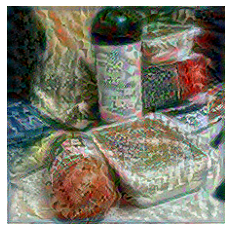

In [130]:
best_img = cv2.cvtColor(best_img, cv2.COLOR_BGR2RGB)
plt.imshow(best_img)
plt.axis(False)

print(best_loss)



In [ ]:
image = Image.fromarray(best_img.astype('uint8'), 'RGB')
image.save("result.jpg")
files.download("result.jpg")